In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import warnings
from sklearn.svm import SVC, NuSVC, SVR
from scipy import stats
from constants import *
from auxiliary_functions import *
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, VotingClassifier, AdaBoostClassifier, BaggingRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from collections import namedtuple
from sklearn.decomposition import PCA
from os import cpu_count
from TwoGroupsWeightedModel import TwoGroupsWeightedModel
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import iqr, kurtosis, skew
from create_nqi_features_with_hand_direction_partition import create_nqi_features_from_raw_data_with_sides_partitions
from method1_feature_extraction import *
from plots import *


### Configuration Constants

In [3]:
PROCESS_DATA_FILES = False  # if set to False, data will be loaded from saved files
CALCULATE_FEATURES = False
SHOW_PLOTS = True  # if true, plots will be printed in the quantiles filter section of the data


# Load Data

##Load full users and taps datasets from Kaggle

In [4]:
from KaggleDataLoader import *

if not PROCESS_DATA_FILES:
    kaggle_taps = pd.read_csv(KAGGLE_TAPS_INPUT)
    print("Kaggle taps dataframe:")
    print(kaggle_taps.head())
    kaggle_users = pd.read_csv(KAGGLE_USERS_INPUT)
    print("Kaggle users dataframe:")
    print(kaggle_users.head())

else:
    # Create dataframe from files, perform basic cleaning
    kaggle_users = create_merged_users_details_file()
    print("Kaggle users dataframe:")
    print(kaggle_users.head())
    
    kaggle_taps = create_merged_taps_dataframe()
    kaggle_taps = clean_bad_values(kaggle_taps)
    kaggle_taps = clean_incompatible_user_ids(kaggle_taps, kaggle_users)
    print("Kaggle taps initial dataframe:")
    print(kaggle_taps.head())


Kaggle taps dataframe:
   FlightTime          ID Hand Direction  LatencyTime  HoldTime binIndex
0       156.3  0EA27ICBLF    L        LL        234.4     101.6  (0, 90]
1       359.4  0EA27ICBLF    L        LL        437.5      85.9  (0, 90]
2       125.0  0EA27ICBLF    L        LL        210.9      78.1  (0, 90]
3       281.3  0EA27ICBLF    L        LL        359.4      62.5  (0, 90]
4        93.8  0EA27ICBLF    S        LS        187.5     125.0  (0, 90]
Kaggle users dataframe:
   BirthYear     DA DiagnosisYear  Gender          ID  Impact  Levadopa  \
0     1952.0   True          2000  Female  0EA27ICBLF  Severe      True   
1     1959.0  False        ------  Female  0QAZFRHQHW  ------     False   
2     1946.0  False        ------  Female  0WTDIGPSBZ  ------     False   
3     1944.0  False        ------    Male  1HOEBIGASW  ------     False   
4     1953.0  False          2017    Male  1WMVCCU4RH  Medium     False   

    MAOB  Other  Parkinsons Sided  Tremors       UPDRS  
0  Fals

Filter outliers

In [5]:
if PROCESS_DATA_FILES:
    def filter_column_by_quantile(df, column, threshold):
        len_before = len(df)
        df = df[df[column] < np.percentile(df[column], threshold)]
        len_after = len(df)
        print("Filtered out {} rows with outliers in column '{}'".format((len_before - len_after), column))
        return df
    
    
    def plot_percentiles_of_column(df, col, start, end, bins):
        X = np.linspace(start, end, bins)
        Y = [np.percentile(df[col], x) for x in X]
        plt.plot(X, Y)
        plt.title(col + " Percentiles")
        plt.xlabel("Percent")
        plt.ylabel("Percentile Value")
        plt.show()
    
    
    # Filter out outliers of HoldTime:
    plot_percentiles_of_column(kaggle_taps, 'HoldTime', 99.96, 99.9999, 20)
    # After the percentile 99.993 we see significantly higher values, which are definitely outliers.
    kaggle_taps = filter_column_by_quantile(kaggle_taps, 'HoldTime', 99.993)


Calculate time bins and build final dataframe

In [6]:
if PROCESS_DATA_FILES:

    # Add parsed date and time column + calculate cumulative time
    kaggle_taps = add_cumulative_timestamps_column(kaggle_taps)
    
    # Group to bin indexes by the cumulative timestamps
    def build_bins(df, bin_size_seconds):
        df["PressTimeCumulative"] = df["PressTimeCumulative"] / 1000
        max_press = (int(max((df["PressTimeCumulative"])) / bin_size_seconds) + 1) * bin_size_seconds + 1
        user_bins = [i for i in range(0, max_press, bin_size_seconds)]
        df["binIndex"] = pd.cut((df["PressTimeCumulative"]), user_bins)
        return df
    
    
    kaggle_taps = build_bins(kaggle_taps, 90)
    
    # Keep only necessary columns and save to file
    kaggle_taps = kaggle_taps[TAPS_FINAL_COLUMNS + ['binIndex']]
    print("Kaggle taps final dataframe:")
    print(kaggle_taps.head())
    
    kaggle_taps.to_csv(constants.KAGGLE_TAPS_INPUT, index=False)

###Summary plots on Kaggle data

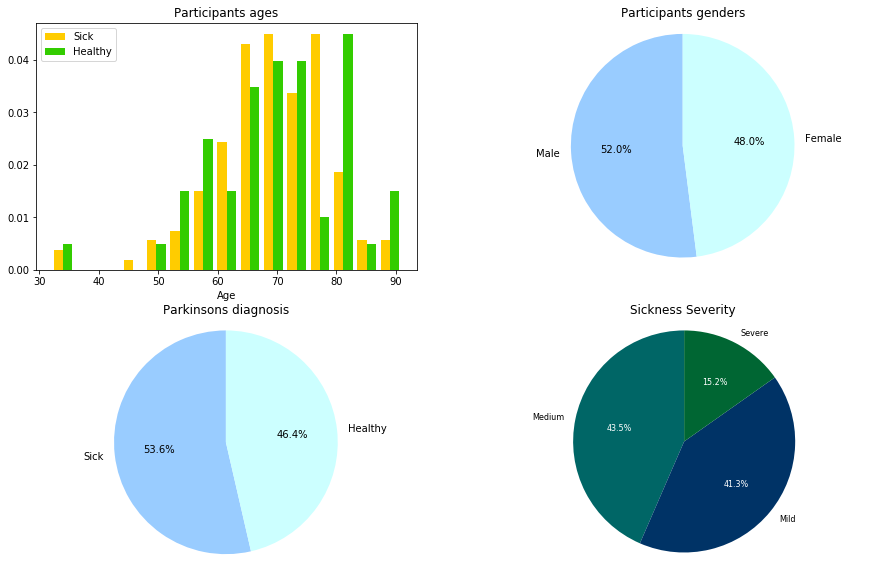

In [7]:
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore pandas warning caused by an internal call to deprecated 'reshape'

ages = add_age_column(kaggle_users)
mild_users = keep_only_mild_users(kaggle_users)

# general statistics of the users
fig = plt.figure(figsize=(15, 10))
ages_plot(fig, ages)
genders_plot(fig, mild_users)
diagnosis_plot(fig, mild_users)
sickness_level_plot(fig, ages)

warnings.resetwarnings()

####In-depth analysis of the values in 'HoldTime'
An important finding that we had during the analysis of the Kaggle data, is that there is a significant number of specific 'HoldTime' values that occur hundreds of thousands of times in the data, sometimes even in a series of sequential keystrokes, in a pattern that is totally unlikely.

10 most common values in 'HoldTime' and their count:
HoldTime
82.0     235253
117.2    260154
70.3     264541
125.0    304250
101.6    323205
85.9     339476
62.5     352945
109.4    387298
93.8     490810
78.1     645667
Name: HoldTime, dtype: int64


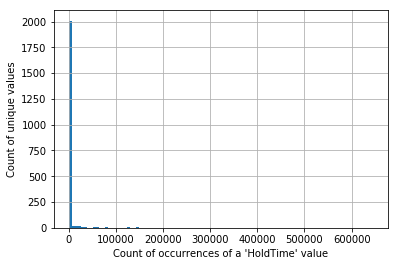

In [8]:
holdTimeCounters = kaggle_taps.groupby(['HoldTime']).HoldTime.count().sort_values()
print("10 most common values in 'HoldTime' and their count:")
print(holdTimeCounters.tail(10))
h = holdTimeCounters.hist(bins=100).set(xlabel="Count of occurrences of a 'HoldTime' value", ylabel="Count of unique values")

We can see that most of the values appear less than 200 times, while there are some extreme values that appear hundred of thousand of time.

As an example, let's focus on the extreme value '78.1'. If it was a valid normal value, we would expect to see that the density of it's appearance count should be similar to those of values around it. Let's plot the histogram around the value '78.1': 

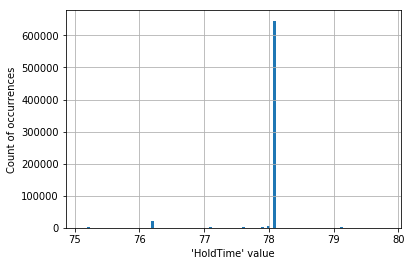

In [9]:
h = kaggle_taps[(kaggle_taps.HoldTime < 80) & (kaggle_taps.HoldTime > 75)].HoldTime \
    .hist(bins=100).set(xlabel="'HoldTime' value", ylabel="Count of occurrences")

We can see that the value is '78.1' is extremely common (>600,000 occurrences) while other close values are rare.
We therefore conclude that the Kaggle data has built-in corrupted entries which are hard to distinguish from the correct ones, so we decided to continue working with the original data but keeping in mind the understanding that the signal could be corrupted.

##Load full users and taps datasets from MIT dataset

In [10]:
from MITDataLoader import *

if not PROCESS_DATA_FILES:
    mit_taps = pd.read_csv(MIT_TAPS_INPUT)
    print("MIT taps dataframe:")
    print(mit_taps.head())
    mit_users = pd.read_csv(MIT_USERS_INPUT)
    print("MIT users dataframe:")
    print(mit_users.head())

else:
    mit_users = pd.read_csv(USERS, delimiter=',', header=0, error_bad_lines=False,
                            low_memory=False, usecols=["pID", "gt", "updrs108", "file_1", "file_2"])
    
    mit_taps = create_merged_taps_dataframe()
    print("MIT taps initial dataframe:")
    print(mit_taps.head())
    mit_taps = clean_errors_and_bad_values(mit_taps)
    

MIT taps dataframe:
   ID Hand Direction  HoldTime   LatencyTime  FlightTime  pressTime binIndex
0  68    R        LR     119.4  1.401115e+12      1766.2     1.8314  (0, 90]
1  68    L        RL     133.7  5.904000e+02       471.0     2.4218  (0, 90]
2  68    L        LL     184.7  4.731000e+02       339.4     2.8949  (0, 90]
3  68    L        LL     149.9  3.464000e+02       161.7     3.2413  (0, 90]
4  68    R        LR     213.7  7.203000e+02       570.4     3.9616  (0, 90]
MIT users dataframe:
   ID  Parkinsons  UPDRS
0  11        True  14.25
1  60       False   2.00
2  67        True  25.25
3  68       False   6.00
4  70        True  26.25


Calculate time bins and build final dataframe

In [11]:
if PROCESS_DATA_FILES:

    # Group to bin indexes by pressTime and add as a new column
    bin_size_seconds = 90
    max_press = (int(max(mit_taps["pressTime"]) / bin_size_seconds) + 1) * bin_size_seconds + 1
    user_bins = [i for i in range(0, max_press, bin_size_seconds)]
    mit_taps["binIndex"] = pd.cut(mit_taps["pressTime"], user_bins)


Filter outlier

In [12]:
if PROCESS_DATA_FILES:
    
    def plot_percentile(df, column, start, end, bins):
        X = np.linspace(start, end, bins)
        Y = [np.percentile(df[column], x) for x in X]
        plt.plot(X, Y)
        plt.title(column + " Percentiles")
        plt.xlabel("Percent")
        plt.ylabel("Percentile Value")
        plt.show()
    
    
    def filter_column_by_quantile(df, column, threshold):
        len_before = len(df)
        df = df[df[column] < np.percentile(df[column], threshold)]
        len_after = len(df)
        print("Filtered out {} rows with outliers in column '{}'".format((len_before - len_after), column))
        return df
    
    
    if SHOW_PLOTS:
        for col in list(set(FLOAT_COLUMNS) - {"pressTime"}):
            plot_percentile(mit_taps, col, 98, 99.9999, 40)
    
    # Filter according to the results in the plots
    mit_taps = filter_column_by_quantile(mit_taps, "HoldTime", 99.99)
    mit_taps = filter_column_by_quantile(mit_taps, "LatencyTime", 99.4)
    mit_taps = filter_column_by_quantile(mit_taps, "FlightTime", 99.95)


Save final dataframe

In [13]:
if PROCESS_DATA_FILES:

    # Save to file - Taps file
    mit_taps[["HoldTime", "LatencyTime", "FlightTime"]] = \
        1000 * mit_taps[["HoldTime", "LatencyTime", "FlightTime"]]  # to milliseconds
    print("MIT taps final dataframe:")
    print(mit_taps.head())
    
    mit_taps.to_csv(MIT_TAPS_INPUT, index=False)
    
    # Save to file - Users file
    mit_users.rename(columns={'pID': 'ID', 'gt': 'Parkinsons', 'updrs108': 'UPDRS'}, inplace=True)
    mit_users = mit_users[['ID', 'Parkinsons', 'UPDRS']]
    print("MIT users dataframe:")
    print(mit_users.head())
    
    mit_users.to_csv(MIT_USERS_INPUT, index=False)

Summary plots on MIT data

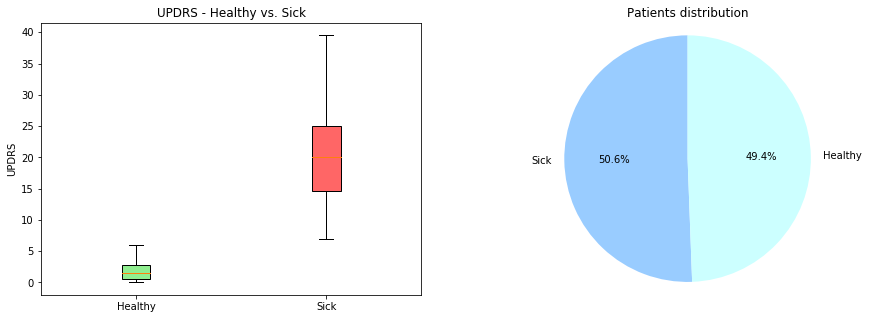

In [14]:
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore pandas warning caused by an internal call to deprecated 'reshape'

fig = plt.figure(figsize=(15, 5))
mit_updrs_distribution(fig, mit_users)
mit_diagnosis(fig, mit_users)

warnings.resetwarnings()

#Feature Creation

##1.Creating features from the Kaggle data set, according to the first method:

In [15]:
# For every patient, calculate summary statistics for all of their data, partitioned into Left/Right, 
# and LR/RL/LL/RR transitions: 

if CALCULATE_FEATURES:
    method1_features = create_summary_statistics(kaggle_taps,
                                                 columns_to_aggregate=["FlightTime", "HoldTime", "LatencyTime"],
                                                 aggregation_functions=[np.mean, np.std, stats.kurtosis, stats.skew,
                                                            stats.entropy, percnt10, percnt20, percnt40, percnt60, percnt70,
                                                            percnt80, percnt90])
    # Add a feature of the mean-diff between Left and Right HoldTimes, and Between LR and RL LatencyTimes:
    method1_features["mean_diff_L_R_HoldTime"] = method1_features.R_HoldTime_mean - method1_features.L_HoldTime_mean
    method1_features["mean_diff_LR_RL_LatencyTime"] = method1_features.RL_LatencyTime_mean - method1_features.LR_LatencyTime_mean
    method1_features["mean_diff_LL_RR_LatencyTime"] = method1_features.LL_LatencyTime_mean - method1_features.RR_LatencyTime_mean
    
    # Join with the Users data:
    method1_features = method1_features.merge(kaggle_users, on="ID", how="left")
    # Dump to csv:
    method1_features.to_csv(KAGGLE_DATA_ARTICLE_METHOD1_FEATURES)
else:
    method1_features = pd.read_csv(KAGGLE_DATA_ARTICLE_METHOD1_FEATURES)
    
print(method1_features.head())

   Unnamed: 0          ID  L_FlightTime_mean  L_FlightTime_std  \
0           0  0EA27ICBLF         239.655394        107.822976   
1           1  0QAZFRHQHW         319.277429        162.896291   
2           2  1HOEBIGASW         386.722581        175.209404   
3           3  1XNJCXS3EY         226.013786         85.352172   
4           4  2JTCBKUP8T         265.411441        160.215877   

   L_FlightTime_kurtosis  L_FlightTime_skew  L_FlightTime_entropy  \
0              -1.263192          -0.032858             11.148338   
1              -0.659685           0.361020              6.322468   
2              -0.927794          -0.326568              3.319654   
3              -0.493719          -0.125464              6.045913   
4              -0.093353           0.540118              8.959632   

   L_FlightTime_percnt10  L_FlightTime_percnt20  L_FlightTime_percnt40  \
0                   93.8                  125.0                 203.10   
1                  117.2                

In [16]:
# Filter the data so that we only keep patients with plenty of tapping events, and only patients with mild Parkinsons:
method1_features = method1_features[method1_features.total_count >= TAPS_THRESHOLD]  # take only users with more than THRESHOLD keystrokes
method1_features = method1_features[method1_features.Levadopa.astype(str) == 'False']
method1_features = method1_features[(method1_features.Parkinsons.astype(str) == 'False') | ( (method1_features.Parkinsons.astype(str) == 'True') & (method1_features.Impact == "Mild"))]



plot for features data

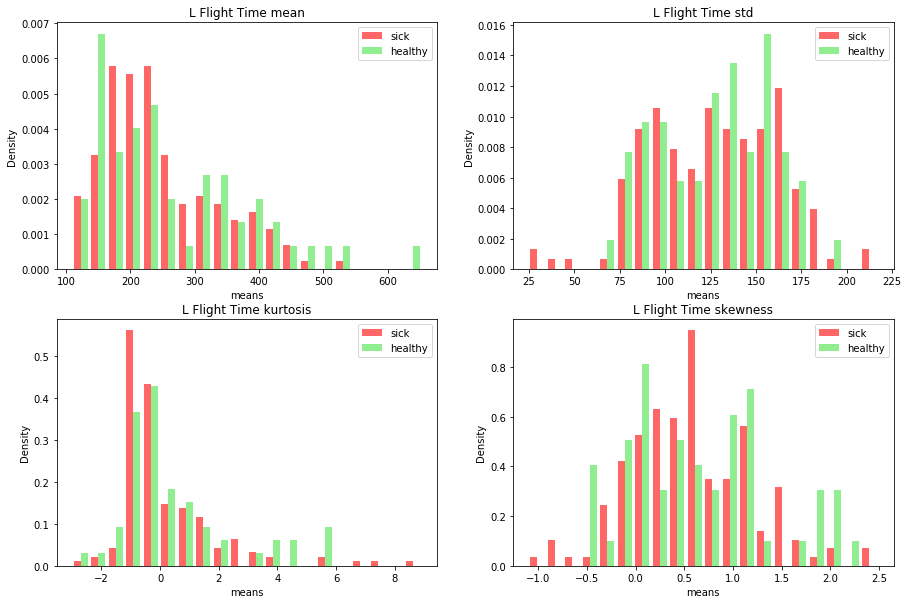

In [40]:
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore pandas warning caused by an internal call to deprecated 'reshape'

feat = pd.read_csv(KAGGLE_FINAL_DATASET)
sick = feat.loc[(feat['Parkinsons'] == True)]
healthy = feat.loc[(feat['Parkinsons'] == False)]

fig = plt.figure(figsize=(15, 10))

lFlight_mean(fig, sick, healthy)
lFlight_std(fig, sick, healthy)
lFlight_kurtosis(fig, sick, healthy)
lFlight_skew(fig, sick, healthy)

warnings.resetwarnings()

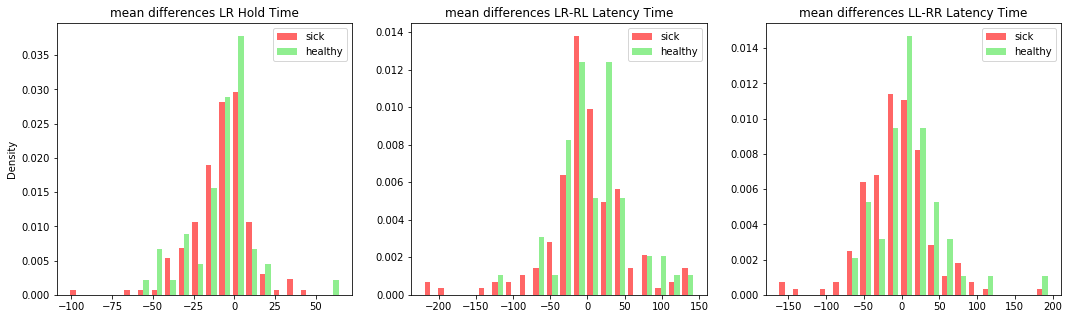

In [18]:
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore pandas warning caused by an internal call to deprecated 'reshape'

fig = plt.figure(figsize=(18, 5))

LR_Hold_Time(fig, healthy, sick)
LR_RL_Latency_Time(fig, healthy, sick)
LL_RR_Latency_Time(fig, healthy, sick)

warnings.resetwarnings()

#Modeling Phase 1: Attempting to reproduce the results from the Kaggle challenge article

In [19]:
# The summary statistics used in the original article:
ARTICLE_EXPLANATORY_VARIABLES =['L_HoldTime_mean', 'L_HoldTime_std', 'L_HoldTime_kurtosis', 'L_HoldTime_skew',
 'R_HoldTime_mean', 'R_HoldTime_std', 'R_HoldTime_kurtosis', 'R_HoldTime_skew', 'LL_LatencyTime_mean', 'LL_LatencyTime_std',
 'LL_LatencyTime_kurtosis', 'LL_LatencyTime_skew', 'LR_LatencyTime_mean', 'LR_LatencyTime_std', 'LR_LatencyTime_kurtosis',
 'LR_LatencyTime_skew', 'RL_LatencyTime_mean', 'RL_LatencyTime_std', 'RL_LatencyTime_kurtosis', 'RL_LatencyTime_skew',
 'RR_LatencyTime_mean', 'RR_LatencyTime_std', 'RR_LatencyTime_kurtosis', 'RR_LatencyTime_skew', 'mean_diff_LR_RL_LatencyTime',
 'mean_diff_LL_RR_LatencyTime', 'mean_diff_L_R_HoldTime']




### First attempt: applying several models to the raw data with the variables used in the article, without further processing:


In [20]:
X = method1_features[ARTICLE_EXPLANATORY_VARIABLES]
y = method1_features["Parkinsons"]
classifiers = [LogisticRegression(),
               RandomForestClassifier(),
               AdaBoostClassifier(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(),
               SVC(kernel='rbf', probability=True),
               ]
for final_classifier in classifiers:
    accuracy = evaluate_classifier_cv(final_classifier, X, y, cross_validation_folds=5)
    print(str(final_classifier).split("(")[0] + ":")
    print("\t"+accuracy.train)
    print("\t" + accuracy.test)

LogisticRegression:
	Train accuracy:0.7885
	Test accuracy (5-fold cross validation):0.4782


RandomForestClassifier:
	Train accuracy:0.9808
	Test accuracy (5-fold cross validation):0.6091


AdaBoostClassifier:
	Train accuracy:1.0
	Test accuracy (5-fold cross validation):0.4618
KNeighborsClassifier:
	Train accuracy:0.6538
	Test accuracy (5-fold cross validation):0.5582


GradientBoostingClassifier:
	Train accuracy:1.0
	Test accuracy (5-fold cross validation):0.6
SVC:
	Train accuracy:1.0
	Test accuracy (5-fold cross validation):0.6345


we can see that all models are highly overfitted, and do not perform well.

### Second attempt: normalize the data and apply PCA dimensionality reduction

In [21]:
scaler = StandardScaler()
normalized_X = scaler.fit_transform(X)

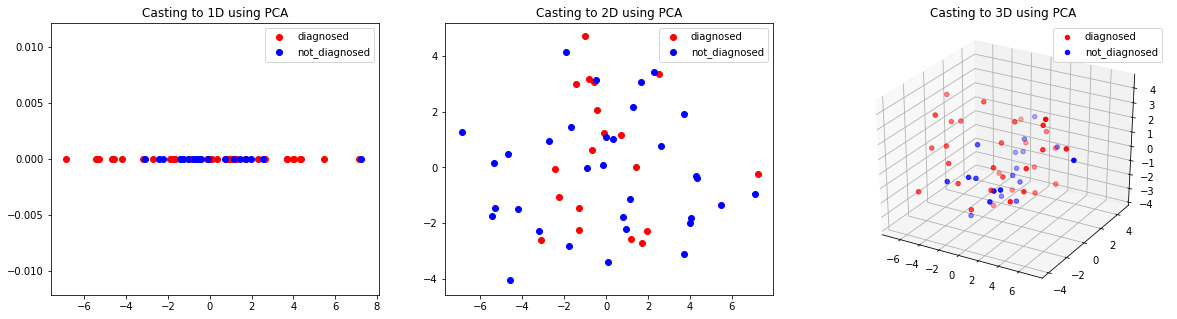

In [22]:
# Visualizing the data in 3d, 2d and 1d after PCA:

pca = PCA(n_components=1)
reduced_X = pca.fit_transform(normalized_X)
_1d_res = get_labeled_data_1d(reduced_X, y)

pca = PCA(n_components=2)
reduced_X = pca.fit_transform(normalized_X)
_2d_res = get_labeled_data_2d(reduced_X, y)

pca = PCA(n_components=3)
reduced_X = pca.fit_transform(normalized_X)
_3d_res = get_labeled_data_3d(reduced_X, y)

plot_dimensionality_reduction(_1d_res, _2d_res, _3d_res)

In [23]:
original_dim = len(normalized_X[0])
tested_dimensions = []
accuracies = []
for dim in [i for i in range(1, original_dim+1)]:
    if dim != original_dim:
        pca = PCA(n_components=dim)
        reduced_X = pca.fit_transform(normalized_X, y.values)
    else:
        reduced_X = normalized_X
    best_accuracy = namedtuple("best_accuracy", "clf_name test_accuracy train_accuracy")
    best_accuracy.test_accuracy = -1  #init
    for clf in classifiers:
        accuracy = evaluate_classifier_cv(clf, reduced_X, y, cross_validation_folds=10)
        if accuracy.test_score > best_accuracy.test_accuracy:
            best_accuracy.test_accuracy = accuracy.test_score
            best_accuracy.clf_name = str(clf).split("(")[0]
    tested_dimensions.append(dim)
    accuracies.append(best_accuracy.test_accuracy)
plt.title("Best test accuracy by dimension (reduction with PCA)")
plt.xlabel("Dimension")
plt.ylabel("Test accuracy rate")
plt.plot(tested_dimensions, accuracies)


KeyboardInterrupt: 

We can see that PCA dimensionality reduction does not improve prformance.

We can see that the above method works well, providing similar results to those described in the article (our result lie within the CI of the AUC achieved in the Nature article).
We've tested some other approaches, and found the following to be more effective - we use a large forest of boosted regression trees onstead of the support-vector regression ensemble:

In [24]:
# Apply LDA dim-reduction and scaling to the data, and randomly split test and train sets:

# TODO: this section and the next one have very variable results (some runs even get AUC of 0.8...). maybe use K-fold-CV to reduce variance.


train_X, train_y, test_X, test_y = split_to_train_test_and_apply_scaling_and_lda_dim_reduction(X, y, 
                                                                                               train_percentage=0.7)

# Fit several models, and find the best one by AUC measure:
best_auc, best_clf = get_best_roc(classifiers, train_X, train_y, test_X, test_y)
print("best AUC after LDA dimensionality reduction:", best_auc, " (by model: {})".format(type(best_clf).__name__))

C:\Users\Nili\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Nili\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Nili\PycharmProjects\DSworkshop\auxiliary_functions.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
C:\Users\Nili\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y

best AUC after LDA dimensionality reduction: 0.44545454545454544  (by model: AdaBoostClassifier)


C:\Users\Nili\PycharmProjects\DSworkshop\auxiliary_functions.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model.fit(train_X, train_y)
C:\Users\Nili\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


It is evident that neither technique of dimensionaliy reduction improves performance. 
We now explore adding additional predictors, specifically calculating percentles of the HoldTime and LatencyTime, trying to better describe the distribution of these measures for each patient:

In [25]:
PERCENTILES = [c for c in method1_features.columns.values if "perc" in c and "FlightTime" not in c]
X = method1_features[ARTICLE_EXPLANATORY_VARIABLES + PERCENTILES]
y = method1_features["Parkinsons"]

train_X, train_y, test_X, test_y = split_to_train_test_and_apply_scaling_and_lda_dim_reduction(X, y, 
                                                                                               train_percentage=0.7)
# Fit several models, and find the best one by AUC measure:
best_auc, best_clf = get_best_roc(classifiers, train_X, train_y, test_X, test_y)
print("best AUC with additional variables:", best_auc, " (by model: {})".format(type(best_clf).__name__))

C:\Users\Nili\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Nili\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Nili\PycharmProjects\DSworkshop\auxiliary_functions.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
C:\Users\Nili\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y

best AUC with additional variables: 0.7272727272727273  (by model: LogisticRegression)


C:\Users\Nili\PycharmProjects\DSworkshop\auxiliary_functions.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model.fit(train_X, train_y)
C:\Users\Nili\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


We now continue to follow the method descdribed in the article, by partitioning the data into two groups, Hold variables and Latency variables (depending on the orignal column they were created by). 
We then assign a Parkinson's probability using each group seperately, and output a final probability as a weighted average of these two probabilities.

In [26]:
from TwoGroupsWeightedModel import TwoGroupsWeightedModel
import warnings

ALL_VARIABLES = ARTICLE_EXPLANATORY_VARIABLES
HOLD_VARIABLES = [v for v in ALL_VARIABLES if "HoldTime" in v]
LATENCY_VARIABLES = [v for v in ALL_VARIABLES if "LatencyTime" in v]

voting_ensemble = VotingClassifier(estimators=[
                                    ('1', RandomForestClassifier()),
                                    ('2', SVC(probability=True)),
                                    ('3', MLPClassifier()),
                                    ('4', LogisticRegression()),
                                    ('5', NuSVC(probability=True)),
                                    ('6', KNeighborsClassifier()),
                                    ('7', DecisionTreeClassifier()),
                                    ('8', QuadraticDiscriminantAnalysis())
                                  ],
                        voting='soft')


def weighting_function(hold_probs, latency_probs):
    """
    These are the weights described in the article. We note that this weighting can yield probs > 1, and therefore is not optimal. 
    We've tried other weightings as well, with no significant improvement.
    """
    return (hold_probs + 0.5*(1-1.2) + 1.2*latency_probs)/2.0


groups_model = TwoGroupsWeightedModel(underlying_estimator_module_and_class="sklearn.pipeline Pipeline",
                            group1_var_names=HOLD_VARIABLES,
                            group2_var_names=LATENCY_VARIABLES,
                             weighting_function=weighting_function,              
                            classification_threshold=0.5,
                            steps=[("normalization", StandardScaler()),
                                   ("lda", LinearDiscriminantAnalysis()),
                                   ("clf", voting_ensemble)])

# calculate accuracy and AUC for the groups-model, using K-fold CV:
X = method1_features[ARTICLE_EXPLANATORY_VARIABLES]
y = method1_features["Parkinsons"]

"""
Training the model on this data results in a "Collinear Variables" warnings. This is true, as some of the variables have very high Pearson-correlation.
In order to reporoduce the article findings we ignore these erros for now, and  filter warnings for the next few lines. 
"""
warnings.filterwarnings("ignore")
test_auc = evaluate_classifier_cv(clf=groups_model, X=X, y=y, cross_validation_folds=5, scoring='roc_auc').test_score
test_accuracy = evaluate_classifier_cv(clf=groups_model, X=X, y=y, cross_validation_folds=5, scoring='accuracy').test_score
warnings.resetwarnings()

print("Test AUC: {}\nTest Accuracy: {}".format(test_auc, test_accuracy))

Test AUC: 0.3399365079365079
Test Accuracy: 0.5163636363636364


Conclusion: in the above section we tried to reproduce and improve the classifying technique described in the article that inspired the Kaggle challenge. 
We believe that the the results in the aticle are not valid and non-reproducible, and we ellaborate further on this in the project document.

#Modeling Phase 2: A completely different approah, inspired by results published by a team of MIT researchers

We first construct the features for the "nqi-regression":

In [27]:
from nqi_feature_creation_functions import *
MIN_PRESSES_PER_BUCKET_THRESHOLD = 1 # Filtering on a higher value did not prove usefull

# Create the NQI features for both the MIT and the Kaggle Datasets:
i = 1
if CALCULATE_FEATURES:
    for taps_input_file_path, nqi_features_output_filepath in \
            zip([MIT_TAPS_INPUT, KAGGLE_TAPS_INPUT], [MIT_NQI_FEATURES, KAGGLE_NQI_FEATURES]):
        print("Creating features for dataset #{}...".format(i))
        taps = pd.read_csv(taps_input_file_path)
        len_before = len(taps)
        taps = taps.groupby(["ID", "binIndex"]).filter(lambda x: x['HoldTime'].count() > MIN_PRESSES_PER_BUCKET_THRESHOLD)
        print("\tRemoved {} rows from time-windows containing too few taps in file.".format(len_before - len(taps)))
        
        # Filter out time-windows where the IQR feature cannot be calculated (this happens in the Kaggle data set,
        # due to sparse time windows and HoltTime values that are very common. See project documentation for elaboration on this issue.)
        len_before = len(taps)
        taps = taps.groupby(['ID','binIndex']).filter(lambda x: np.percentile(x.HoldTime, 25) != np.percentile(x.HoldTime, 75) )
        print("\tFiltered {} rows where the IQR feature cannot be calculated.".format(len_before - len(taps)))
        
        grouped_taps = taps.groupby(["ID", "binIndex"])["HoldTime"].agg([agg_outliers, agg_iqr, agg_histogram_bin0, agg_histogram_bin1,
                                                            agg_histogram_bin2, agg_histogram_bin3, np.count_nonzero])
        t = taps.groupby(["ID", "binIndex"])["FlightTime"].agg([np.mean, np.std]).reset_index()
        nqi_calculator_input = grouped_taps.reset_index()
        nqi_calculator_input = nqi_calculator_input.merge(t, on=["ID","binIndex"])
        nqi_calculator_input = nqi_calculator_input.rename(columns={"FlightTime": "mean_flight"})
    
        nqi_calculator_input = nqi_calculator_input[nqi_calculator_input.count_nonzero > MIN_PRESSES_PER_BUCKET_THRESHOLD]
    
        nqi_calculator_input.to_csv(nqi_features_output_filepath, index=False)
        print("\tDone.")
        i += 1

In [28]:
# TODO: remove, this is in aux funcs
def list_diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

mit_nqi_features = pd.read_csv(MIT_NQI_FEATURES)
mit_users = pd.read_csv(MIT_USERS_INPUT)

print(mit_nqi_features.head())

mit_data = mit_nqi_features.merge(mit_users, on="ID").dropna().reset_index().drop("index", axis=1)
PREDICTION_COLUMNS = list_diff(mit_data.columns, ["UPDRS", "Parkinsons", 'binIndex', 'ID', 'count_nonzero'])

# Split the unified MIT dataset to train and test according to ID's:
train_mit_data = mit_data[mit_data.ID <= 100].copy()
test_mit_data = mit_data[mit_data.ID >= 1000].copy()

   ID    binIndex  agg_outliers   agg_iqr  agg_histogram_bin0  \
0  11     (0, 90]      0.026316  0.267750            0.005592   
1  11  (180, 270]      0.022541  0.292350            0.005306   
2  11  (270, 360]      0.038113  0.324675            0.005760   
3  11  (360, 450]      0.032037  0.241379            0.005798   
4  11  (450, 540]      0.026690  0.272031            0.005604   

   agg_histogram_bin1  agg_histogram_bin2  agg_histogram_bin3  count_nonzero  \
0            0.002296            0.000099            0.000014          570.0   
1            0.002579            0.000049            0.000066          488.0   
2            0.002182            0.000044            0.000015          551.0   
3            0.002147            0.000055            0.000000          437.0   
4            0.002239            0.000128            0.000029          562.0   

         mean         std  
0  191.381228  192.488229  
1  243.280328  802.650718  
2  207.004537  273.406422  
3  293.918993  7

In [29]:
# We first define a function that performs the NQI-regression and subsequent classification using the regression's predictions:

def nqi_regression_and_pd_classification(train_data, test_data, regression_model, final_classifier):
    """
    :param train_data, test_data: a DataFrame with NQI-features and regression target ('UPDRS').
    :param regression_model: the regression model that will be used for predicting the nqi score.
    :param final_classifier: the classification model that will be used for predicting Parkinson's/no-Parkinson's based on the predicted nqi score.
    :return: the test AUC of the final model, that uses the predicted-nqi in order to predict Parkinson's.
    """
    scaler = StandardScaler()
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))  # We use this to scale the UPDRS target to the [0,1] interval.
    
    train_X = train_data[PREDICTION_COLUMNS]
    train_y = train_data["UPDRS"]
    
    train_X = pd.DataFrame(scaler.fit_transform(train_X))
    train_y = min_max_scaler.fit_transform(train_y.values.reshape(-1,1))
    
    test_X = test_data[PREDICTION_COLUMNS]
    test_X = pd.DataFrame(scaler.transform(test_X))
    regression_model.fit(X=train_X, y=np.ravel(train_y))

    train_nqi_predictions = regression_model.predict(train_X)
    train_data["predicted_nqi"] = train_nqi_predictions
    # calculate the average predicted-nqi per training patient:
    train_final_df = train_data.groupby("ID")["Parkinsons", "predicted_nqi"].mean().reset_index()

    # predict nqi for every subject in the test-set (as mean of predicted nqi of all the subject's time-windows):
    test_nqi_predictions = regression_model.predict(test_X)
    test_data["predicted_nqi"] = test_nqi_predictions
    test_final_df = test_data.groupby("ID")["Parkinsons", "predicted_nqi"].mean().reset_index()

    # Use the result of the nqi-regression, to predict Parkinsons. To do so, we use another classification model (different models yield similar ersults):
    
    final_classifier.fit(train_final_df["predicted_nqi"].values.reshape(-1, 1), train_final_df["Parkinsons"])

    predicted_test_probs = final_classifier.predict_proba(test_final_df["predicted_nqi"].values.reshape(-1, 1))[:, 1]
    test_set_auc = roc_auc_score(y_true=test_final_df["Parkinsons"], y_score=predicted_test_probs)
    result = namedtuple('result', 'test_auc y_true y_predicted')
    result.test_auc, result.y_true, result.y_predicted  = test_set_auc, test_final_df["Parkinsons"], predicted_test_probs
    
    return result 

In [30]:
# We now apply the nqi regression procedure using a bagging-ensemble of 200 support-vector regressors,
# in accordance with the original research, and use logistic regression as the final classifeir:
# We use LogisticRegression here as the final classifier. Our tests show that most classification models yield very similar results. 
sv_regression_ensemble = BaggingRegressor(base_estimator=SVR(),
                                n_estimators=200,
                                bootstrap=True,
                                n_jobs=1)

nqi_regression_on_mit_data_with_sv_regression_results = nqi_regression_and_pd_classification(train_mit_data, test_mit_data,
                                                regression_model=sv_regression_ensemble,
                                                final_classifier=LogisticRegression()
                                                )
test_auc = nqi_regression_on_mit_data_with_sv_regression_results.test_auc
print("Test AUC using support-vector regression: {}".format(test_auc))

Test AUC using support-vector regression: 0.6902777777777778


We can see that the above method works well, providing similar results to those described in the article (our result lie within the CI of the AUC achieved in the Nature article).
We've tested some other approaches, and found the following to be more effective - we use a large forest of boosted regression trees onstead of the support-vector regression ensemble:

In [31]:
gbt_regression_ensemble = GradientBoostingRegressor(n_estimators=1000)

nqi_regression_on_mit_data_with_gbt_regression_results = nqi_regression_and_pd_classification(train_mit_data, test_mit_data,
                                                regression_model=gbt_regression_ensemble,
                                                final_classifier=LogisticRegression()
                                                )
print("Test AUC using gb-tree regression: {}".format(nqi_regression_on_mit_data_with_gbt_regression_results.test_auc))

Test AUC using gb-tree regression: 0.7236111111111112


In [32]:
# Optimize regressor parameters:

train_X = train_mit_data[PREDICTION_COLUMNS]
train_y = train_mit_data["UPDRS"]

param_space = {
    'n_estimators': [100,500,1000],
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': [0.001,0.01,0.1],
    'max_depth': [1,2,3,5,7,8],
    'max_leaf_nodes': [None, 3, 5, 10, 50, 100]
}

grid_searcher = GridSearchCV(gbt_regression_ensemble, param_grid=param_space, n_jobs=-1, cv=3, verbose=2, scoring="r2")
grid_searcher.fit(X=train_X, y=np.ravel(train_y))
print("Best params:\n", grid_searcher.best_params_)
gbt_regression_ensemble.set_params(grid_searcher.best_params_)

# TODO: run this, and present the auc of the optimized model. 

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.3s


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.5min


[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  8.9min


KeyboardInterrupt: 

We will now try to evaluate the relevance of the above method to home-environment data, by training the nqi-regression model on all of the MIT data, and testing it on the Kaggle data (which is home-environment data):

In [33]:
kaggle_nqi_features = pd.read_csv(KAGGLE_NQI_FEATURES)
kaggle_users_data = pd.read_csv(KAGGLE_USERS_INPUT)
kaggle_data = kaggle_nqi_features.merge(kaggle_users_data, on="ID").dropna().reset_index().drop(["index"], axis=1)

# Remove patients taking Levadopa or patients with non-mild Parkinson's:
kaggle_data = kaggle_data[kaggle_data.Levadopa == False]
kaggle_data = kaggle_data[kaggle_data.Parkinsons == False | ((kaggle_data.Parkinsons == True) & (kaggle_data.Impact == "Mild"))]


# Apply nqi-regression:
nqi_regression_on_kaggle_and_mit_data_with_gbt_regression_results = nqi_regression_and_pd_classification(train_data=mit_data, test_data=kaggle_data, 
                                     regression_model=gbt_regression_ensemble, 
                                     final_classifier=LogisticRegression())
print("Test AUC on MIT data after optimizing regressor hyper-parmeters: {}".format(nqi_regression_on_kaggle_and_mit_data_with_gbt_regression_results.test_auc))

FileNotFoundError: File b'C:\\\\Users\\\\Nili\\\\PycharmProjects\\\\DSworkshop\\\\Data\\\\KAGGLE_NQI_FEATURES.csv' does not exist

We see above that the nqi-regression trained on the MIT data does not generalize well to the Kaggle data. We propose two possible explanations for this: it could be that the MIT data is fundamentally different, being collected in the lab and not at home. Another possible explanation is that the Kaggle data is corrupt (this could explain the inability to reproduce the first article).

# TODO:
1. Insert the left/right partition data with nqi-regression
2. Try adding more features to nqi regression (see presentation)
3. 

In [34]:
# Preparing the MIT data with measures of assymetry:
nqi_features_with_side_partitions_data_path = create_nqi_features_from_raw_data_with_sides_partitions(MIT_TAPS_INPUT, MIT_NQI_FEATURES_SIDES_PARTITIONS)

mit_nqi_features_with_sides_partition = pd.read_csv(nqi_features_with_side_partitions_data_path)
mit_users = pd.read_csv(MIT_USERS_INPUT)

print("NQI features with keyboard side partitions:")
print(sorted(mit_nqi_features_with_sides_partition.columns))

mit_data_with_sides_partition = mit_nqi_features_with_sides_partition.merge(mit_users, on="ID").dropna().reset_index().drop("index", axis=1)
PREDICTION_COLUMNS = list_diff(mit_data_with_sides_partition.columns, ["UPDRS", "Parkinsons", 'binIndex', 'ID', 'count_nonzero'])

# Split the unified MIT dataset to train and test according to ID's:
train_mit_data_with_sides_partitions = mit_data_with_sides_partition[mit_data_with_sides_partition.ID <= 100].copy()
test_mit_data_with_sides_partitions = mit_data_with_sides_partition[mit_data_with_sides_partition.ID >= 1000].copy()


C:\Users\Nili\PycharmProjects\DSworkshop\nqi_feature_creation_functions.py:32: RuntimeWarning: invalid value encountered in double_scalars
  return (second_quartile - first_quartile)/(third_quartile - first_quartile)


KeyboardInterrupt: 

In [35]:
nqi_regression_on_mit_data_with_assymetry_features = nqi_regression_and_pd_classification(train_data=train_mit_data_with_sides_partitions, 
                                                test_data=test_mit_data_with_sides_partitions, 
                                                regression_model=gbt_regression_ensemble, 
                                                final_classifier=LogisticRegression())
print("Test AUC on MIT with assymetry measurement features (keyboard side partitions) : {}".
      format(nqi_regression_on_mit_data_with_assymetry_features.test_auc))

NameError: name 'train_mit_data_with_sides_partitions' is not defined

Conclusion: our attempt to apply measuring assymetry to the process of predicting a patient UPDRS score did not improve the model over what we have previously achieved. This could be a result of the small size of our datatset, which suffers from high dimensionality when we introduce assymetry features. 

In [36]:
# Plot ROC curves for all of the above variations on the model:
plot_multiple_roc_curves([('model with addymetry features', nqi_regression_on_mit_data_with_assymetry_features.y_true,
                           nqi_regression_on_mit_data_with_assymetry_features.y_predicted),                          
                          ('model with gbt regressor', nqi_regression_on_mit_data_with_gbt_regression_results.y_true,
                           nqi_regression_on_mit_data_with_gbt_regression_results.y_predicted),                          
                          ('model with support-vector regressor', nqi_regression_on_mit_data_with_sv_regression_results.y_true,
                           nqi_regression_on_mit_data_with_sv_regression_results.y_predicted),                          
                          ('model trained on Kaggle data', nqi_regression_on_kaggle_and_mit_data_with_gbt_regression_results.y_true,
                           nqi_regression_on_kaggle_and_mit_data_with_gbt_regression_results.y_predicted),                          
                          ], 
                         title="ROC curves for parkinson's classification based on nqi-regression")

NameError: name 'nqi_regression_on_mit_data_with_assymetry_features' is not defined